In [ ]:
# In this notebook I'll load song lists from Fantasy Mixtape League, retrieve the 
# songs' features from Spotify, and create a model to predict how novel songs will score in 
# the league based on a training set of song features and voting from League history.

In [3]:
# import packages
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt 
import seaborn as sns

# get spotify credentials
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
client_credentials_manager = SpotifyClientCredentials(client_id= '6426e18767ac42d78a9c08f41cacba65',
                                                     client_secret= '4a2cdab50e1c4ecd9fc62cae20664e29')
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
# read in data from excel, do a bit of cleanup.
# assemble all songs, across all mixes
allMixes = pd.ExcelFile('/Users/aaronlevi/Documents/fantasyMixtape.xlsx')
nMixes   = len(allMixes.sheet_names)

allSongs = []

for kMix in range(0,nMixes):
    thisMix = pd.read_excel('/Users/aaronlevi/Documents/fantasyMixtape.xlsx', sheet_name=kMix)    
    allSongs.append(thisMix)
    
allSongs = pd.concat(allSongs)
nSongs   = len(allSongs)
allSongs.index = range(0, nSongs)

In [5]:
# get audio spotfiy's audio features, points, and votes for all songs

# preallocate empty fields
songNames   = {}
artistNames = {}
songURI     = {}
spotFeatures = {}

spotFeatures['acousticness'] = []
spotFeatures['danceability'] = []
spotFeatures['energy'] = []
spotFeatures['instrumentalness'] = []
spotFeatures['liveness'] = []
spotFeatures['loudness'] = []
spotFeatures['speechiness'] = []
spotFeatures['tempo'] = []
spotFeatures['valence'] = []
spotFeatures['popularity'] = []
spotFeatures['points'] = []
spotFeatures['votes'] = []

points = [];
votes  = [];

# song loop: get audio features and append to spotFeatures
for iTrack in range(0, nSongs):
    songNames[iTrack]   = allSongs['ARTIST - SONG'][iTrack].split(' - ')[1]
    artistNames[iTrack] = allSongs['ARTIST - SONG'][iTrack].split(' - ')[0]
    
    result = sp.search(songNames[iTrack]) #search query
    nItems = len(result['tracks']['items'])

    for iArtist in range(0, nItems):    
        if result['tracks']['items'][iArtist]['artists'][0]['name'] == artistNames[iTrack]:
           songURI = result['tracks']['items'][iArtist]['uri']
        
    # pull audio features for a songURI
    features = sp.audio_features(songURI)

    # append relevant values
    spotFeatures['acousticness'].append(features[0]['acousticness'])
    spotFeatures['danceability'].append(features[0]['danceability'])
    spotFeatures['energy'].append(features[0]['energy'])
    spotFeatures['instrumentalness'].append(features[0]['instrumentalness'])
    spotFeatures['liveness'].append(features[0]['liveness'])
    spotFeatures['loudness'].append(features[0]['loudness'])
    spotFeatures['speechiness'].append(features[0]['speechiness'])
    spotFeatures['tempo'].append(features[0]['tempo'])
    spotFeatures['valence'].append(features[0]['valence']) 
    spotFeatures['points'].append(allSongs['points'][iTrack])
    spotFeatures['votes'].append(allSongs['votes'][iTrack])
    
    # get 'popularity' from original track info, not the features function
    spotFeatures['popularity'].append(sp.track(songURI)['popularity'])
    
    # get points & votes 
    points.append(allSongs['points'][iTrack])
    votes.append(allSongs['votes'][iTrack])

In [6]:
# get every feature in a 0 to 1 range
# loudness, popularity, and tempo are not already normalized in this way.
def normalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

spotFeatures['loudness']   = normalizeData(spotFeatures['loudness'])
spotFeatures['popularity'] = normalizeData(spotFeatures['popularity'])
spotFeatures['tempo']      = normalizeData(spotFeatures['tempo'])

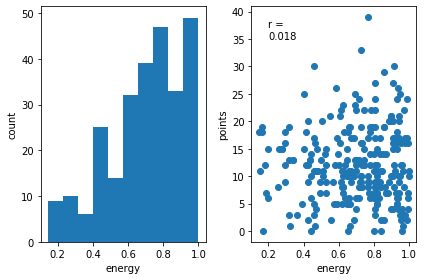

In [39]:
# just out of curiousity, let's visualize one of these variabiles.
# song choices tend to be highly "energetic"
plt.subplot(1,2,1)
plt.hist(spotFeatures['energy'])
plt.xlabel('energy')
plt.ylabel('count')

# but a song's energy doesn't appear to strongly correlate 
# with the no. of points it receives.
plt.subplot(1,2,2)
plt.plot(spotFeatures['energy'], points, 'o')
plt.xlabel('energy')
plt.ylabel('points')

rval = np.corrcoef(spotFeatures['energy'], points)
plt.text(0.2, 37.25, 'r = ')
plt.text(0.2, 35, round(rval[1,0], 3))

plt.tight_layout()

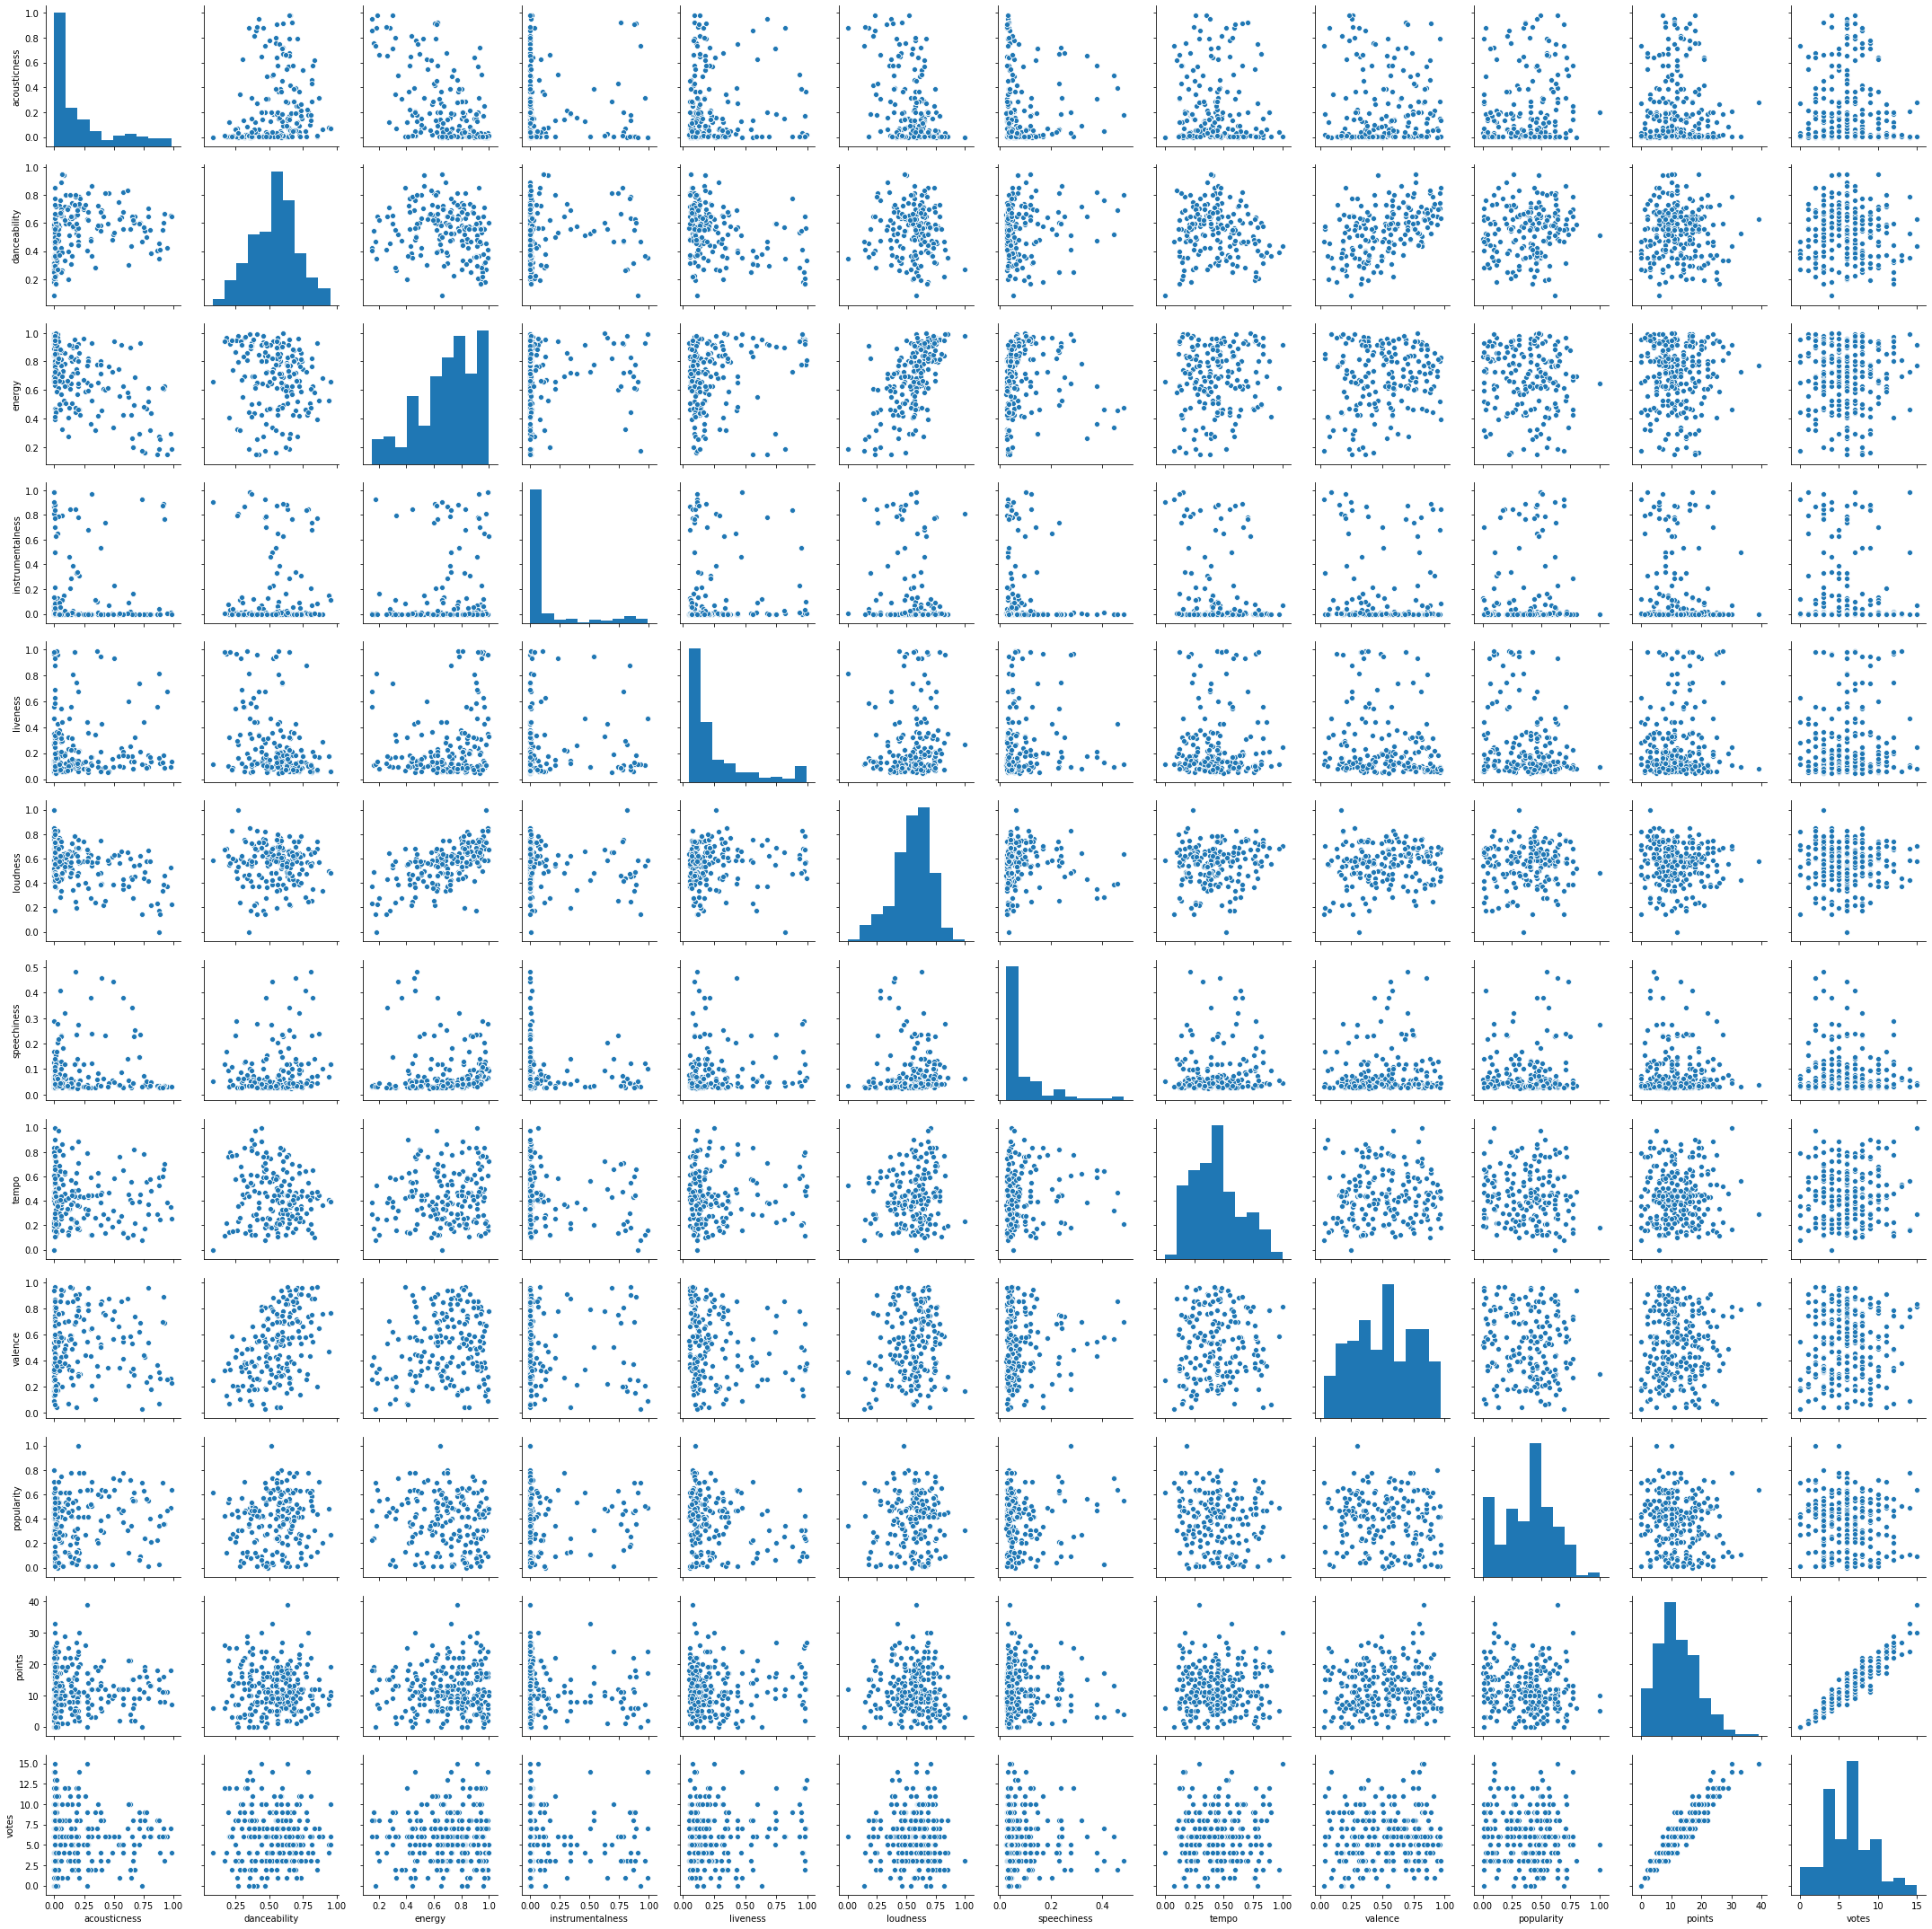

In [41]:
# Let's use pairplot to do a quick visual scan and see if any 
# variables POP out as being strongly correlated with points
#
# The hope is that some of these song features will be obviously
# corerlated with points, and we can then use a simple linear model
# to predict how songs will score.

spotFeatures = pd.DataFrame.from_dict(spotFeatures)
sns.pairplot(spotFeatures)

In [44]:
# None of spotify's song features are very directly related to points in the simplest sense.
# This is still an exercise worth doing however... maybe there are some complex, nonlinear 
# interactions between these terms that may be predictive of points that we just can't see yet.
# Let's train a multi-layered neural net on the data and see if it comes up with anything.

# prepare data for model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.model_selection import train_test_split

#X = spotFeatures[['danceability', 'energy', 'valence']].values
X = spotFeatures[['acousticness','danceability', 'energy', 'instrumentalness',
                  'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence']].values
y = spotFeatures['points'].values

# Leaving this commented out for future reference, but I will actually load in a separate test set later,
# so no need to split the current data in the test & train. 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state = 42)

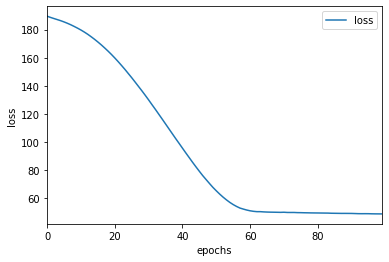

In [46]:
# create neural net
model = Sequential([Dense(4, activation='relu'), 
                   Dense(4 ,activation='relu'),
                   Dense(4 ,activation='relu'),
                   Dense(1)])

model.compile(optimizer='rmsprop', loss='mse')

# train it
model.fit(X_train, y_train, epochs=100, verbose=0)
# plot mse during training to confirm that it plateaus
lossHistory = pd.DataFrame(model.history.history)
lossHistory.plot()
plt.xlabel('epochs')
plt.ylabel('loss')

# get overall ms error
modelMSE = model.evaluate(X_test, y_test, verbose=0)

# use model to make predictions on the test set!
test_predictions= model.predict(X_test)

#from tensorflow.keras.models import load_model
#model.save('fml_pointPredictor.h5')

Text(0, 0.5, 'n songs')

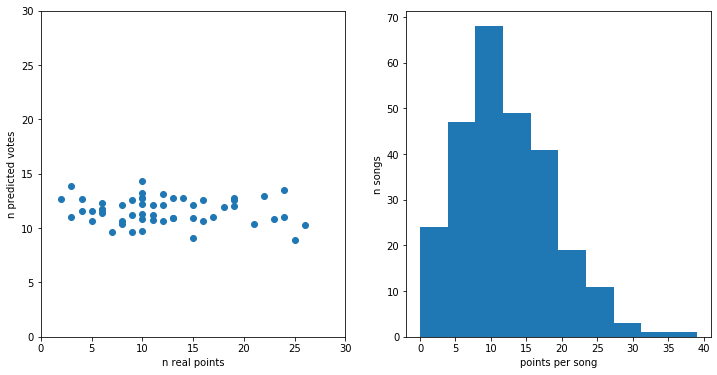

In [47]:
# how'd we do?

# plotting our predicted points per song vs. real points on a left out mix...
# we didn't do very well at all.
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
axes[0].plot(y_test, test_predictions, 'o')
axes[0].set_xlabel('n real points')
axes[0].set_ylabel('n predicted votes')
axes[0].set_xlim([0, 30])
axes[0].set_ylim([0, 30])

# Real quick, let's also just plot the distribution of points in the training data.
# Looks like our model is only predicting in a very small range around the mean 
# points per song in the original training set. 
axes[1].hist(points)
axes[1].set_xlabel('points per song')
axes[1].set_ylabel('n songs')

In [55]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y_test, test_predictions)

5.047667845240179

In [56]:
# Quick look at the mean absolute error in the cell above shows about a
# about 5 point margin of error on predictions, which is pretty huge
# when average no. of points per song is about 11-12. 

# This model has pretty obviously failed... what next? 
# Potential problems/future directions/points of discussion:
#
# 1. Predicting TOTAL votes may be more difficult given that different people
#    have different taste in music. Predicting a single person's voting based
#    on personalized voting history may be easier. 
# 2. These song features alone may never be good predictors... just because a
#    a song has a lot of "energy" doesn't mean it will be highly likable.
#    Likely I'm just missing the best factors to put into this model. So what
#    are they?

In [50]:
# playing around with a novel mix in a separate file.

novelMix = pd.read_excel('/Users/aaronlevi/Documents/novelMix.xlsx')
nSongs   = len(novelMix)

# preallocate empty fields
songNames   = {}
artistNames = {}
songURI     = {}
novelMixFeatures = {}

novelMixFeatures['acousticness'] = []
novelMixFeatures['danceability'] = []
novelMixFeatures['energy'] = []
novelMixFeatures['instrumentalness'] = []
novelMixFeatures['liveness'] = []
novelMixFeatures['loudness'] = []
novelMixFeatures['speechiness'] = []
novelMixFeatures['tempo'] = []
novelMixFeatures['valence'] = []
novelMixFeatures['popularity'] = []

for iTrack in range(0, nSongs):
    songNames[iTrack]   = novelMix['ARTIST - SONG'][iTrack].split(' - ')[1]
    artistNames[iTrack] = novelMix['ARTIST - SONG'][iTrack].split(' - ')[0]
    
    result = sp.search(songNames[iTrack]) #search query
    nItems = len(result['tracks']['items'])

    for iArtist in range(0, nItems):    
        if result['tracks']['items'][iArtist]['artists'][0]['name'] == artistNames[iTrack]:
           songURI = result['tracks']['items'][iArtist]['uri']
        
    # pull audio features for a songURI
    features = sp.audio_features(songURI)

    # append relevant values
    novelMixFeatures['acousticness'].append(features[0]['acousticness'])
    novelMixFeatures['danceability'].append(features[0]['danceability'])
    novelMixFeatures['energy'].append(features[0]['energy'])
    novelMixFeatures['instrumentalness'].append(features[0]['instrumentalness'])
    novelMixFeatures['liveness'].append(features[0]['liveness'])
    novelMixFeatures['loudness'].append(features[0]['loudness'])
    novelMixFeatures['speechiness'].append(features[0]['speechiness'])
    novelMixFeatures['tempo'].append(features[0]['tempo'])
    novelMixFeatures['valence'].append(features[0]['valence']) 
    
    # get 'popularity' from original track info, not the features function
    novelMixFeatures['popularity'].append(sp.track(songURI)['popularity'])

novelMixFeatures['loudness']   = normalizeData(novelMixFeatures['loudness'])
novelMixFeatures['popularity'] = normalizeData(novelMixFeatures['popularity'])
novelMixFeatures['tempo']      = normalizeData(novelMixFeatures['tempo'])    
    
# make a data frame, get things ready for the model
novelMixFeatures = pd.DataFrame.from_dict(novelMixFeatures)    
#X_novel = novelMixFeatures[['danceability', 'energy', 'valence']].values
X_novel = novelMixFeatures[['acousticness','danceability', 'energy', 'instrumentalness',
                  'liveness', 'loudness', 'popularity', 'speechiness', 'tempo', 'valence']].values 

In [51]:
novelMixPoints = model.predict(X_novel)

In [57]:
novelMixPoints[0:11]

array([[10.414653],
       [ 9.197684],
       [12.776024],
       [13.116227],
       [13.116227],
       [13.194033],
       [11.943763],
       [12.157181],
       [ 9.358344],
       [11.033849],
       [12.803977]], dtype=float32)

In [58]:
novelMixPoints[11:]

array([[12.337389 ],
       [12.337389 ],
       [12.97392  ],
       [12.600673 ],
       [12.9847355],
       [13.855559 ],
       [11.367458 ],
       [16.172901 ],
       [11.966394 ],
       [11.713281 ],
       [ 9.67064  ]], dtype=float32)

In [67]:
[songNames[18], songNames[16], songNames[15]]

['“Travelin’ Band”', '“Mama Told Me Not To Come”', '“Yellow Roses”']